# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


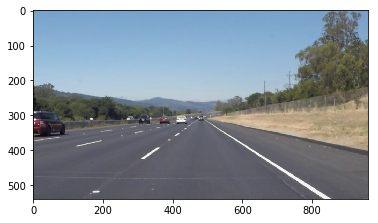

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Helper Functions

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def fit_lines(img, lines, direction):
    height, width, channels = img.shape
    
    avg_x1, avg_y1, avg_x2, avg_y2 = np.mean(lines, axis=0)[0]
    slope, intercept = np.polyfit([avg_x1, avg_x2], [avg_y1, avg_y2], 1)
    roi_height = round(height/2+38) + 30
    bottom_x = math.floor((height - intercept) / slope)
    top_x = math.floor((roi_height - intercept) / slope)
    
    return [(bottom_x, height), (top_x, roi_height)]
    

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    left_lines = []
    right_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0 and slope < -0.5:
                left_lines.append(line)
            elif slope > 0 and slope > 0.5:
                right_lines.append(line)
    if left_lines:
        left_bottom, left_top = fit_lines(img, left_lines, 'left')
        cv2.line(img, left_bottom, left_top, color, thickness)
    
    if right_lines:
        right_bottom, right_top = fit_lines(img, right_lines, 'right')
        cv2.line(img, right_bottom, right_top, color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=5)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



In [5]:
def plot_images(images, grayscale=True):
    if len(images) == 6:
        plt.figure(figsize=(20,10))
        for i, img in enumerate(images, 1):
            plt.subplot(3, 3, i)
            plt.xlabel(test_paths[i-1])
            if grayscale:
                plt.imshow(img, cmap='gray')
            else:
                plt.imshow(img)
    else:
        plt.figure(figsize=(10,5))
        if grayscale:
                plt.imshow(images, cmap='gray')
        else:
            plt.imshow(images)

In [6]:
def transform_images(images, transform_op, show_transform=True, grayscale=True, **args):
    if len(images) == 6:
        transformed_images = [transform_op(image, **args) for image in images]
    else:
        transformed_images = transform_op(images, **args)
    if show_transform:
        plot_images(transformed_images, grayscale)
    return transformed_images

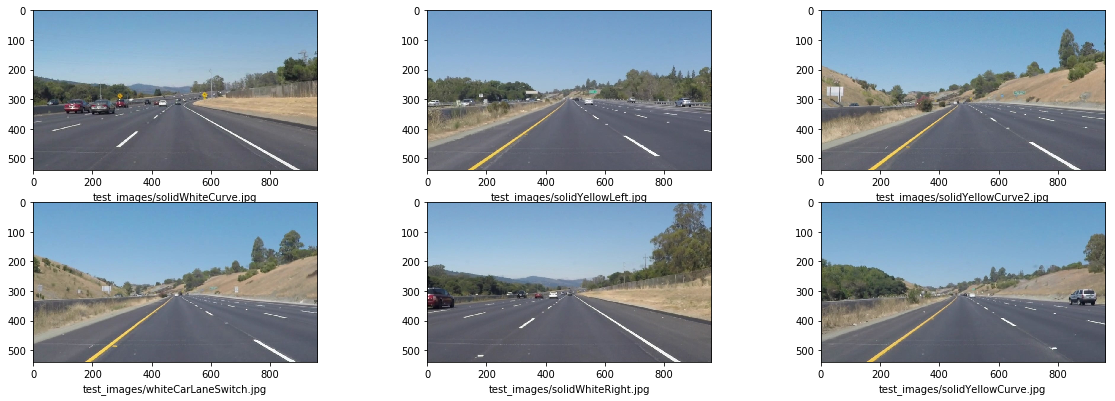

In [7]:
from os import path
test_files = os.listdir('test_images/')
test_paths = [path.join('test_images/', file) for file in test_files]
test_images = [mpimg.imread(path) for path in test_paths]
plt.figure(figsize=(20,10))
plot_images(test_images, grayscale=False)

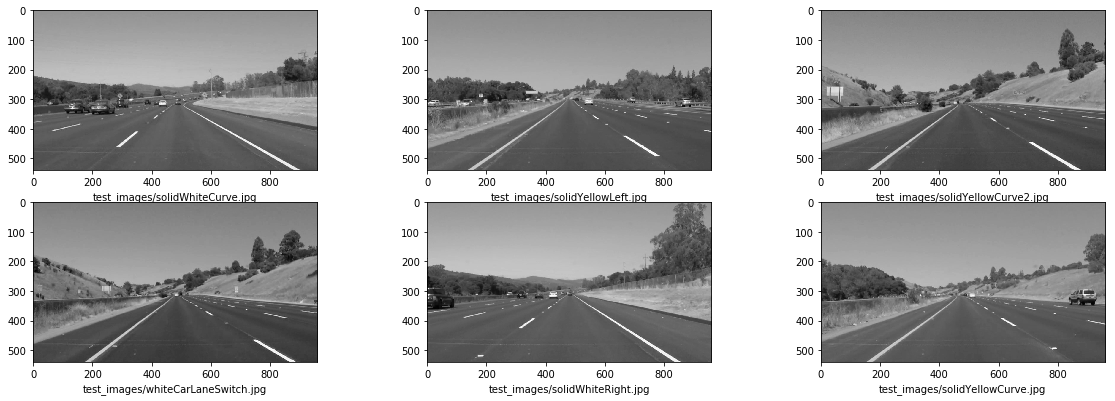

In [8]:
grayscale_images = transform_images(test_images, grayscale)

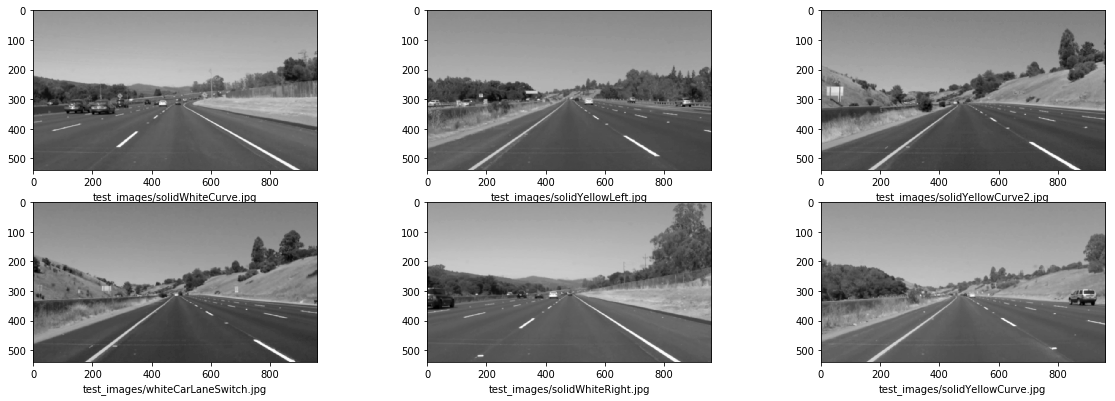

In [9]:
smoothed_images = transform_images(grayscale_images, gaussian_blur, kernel_size=7)

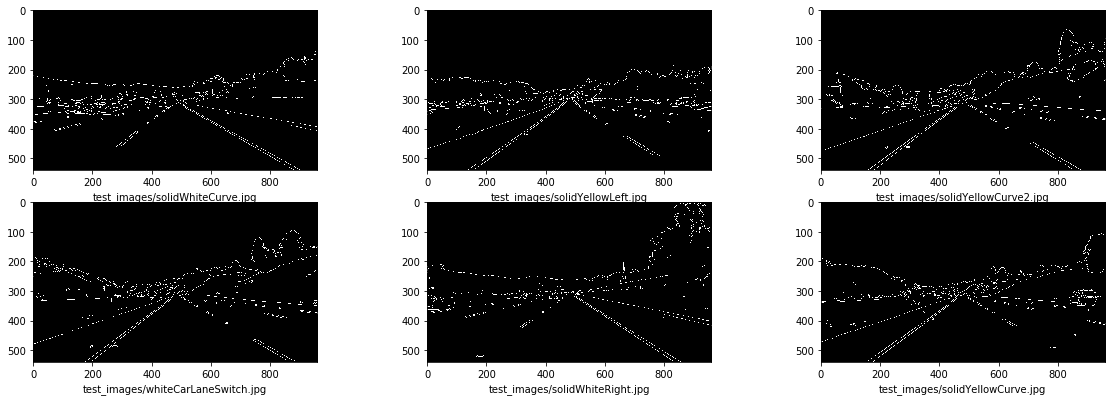

In [10]:
canny_images = transform_images(smoothed_images, canny, low_threshold=50, high_threshold=100)

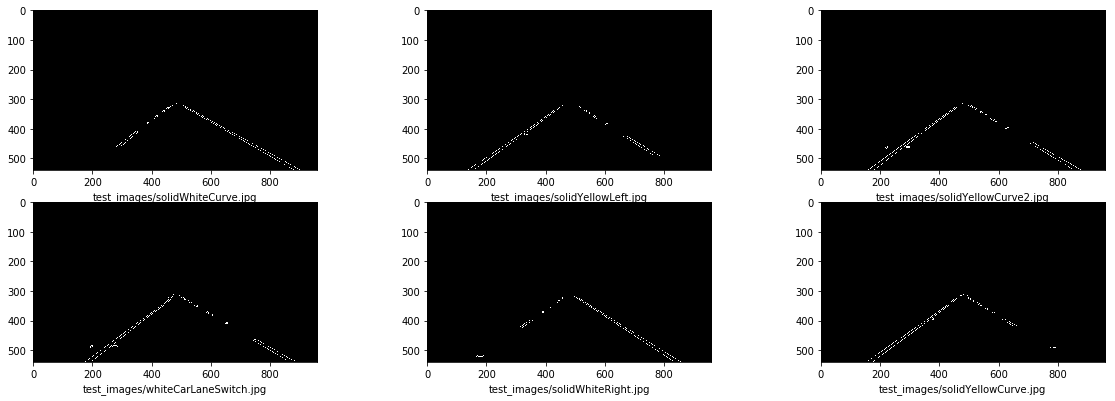

In [11]:
height, width = canny_images[0].shape
roi_images = transform_images(canny_images, region_of_interest, 
                              vertices=np.array([[[round(width/2),round(height/2+38)],
                                                  [80,height],
                                                  [width-20,height]]]))

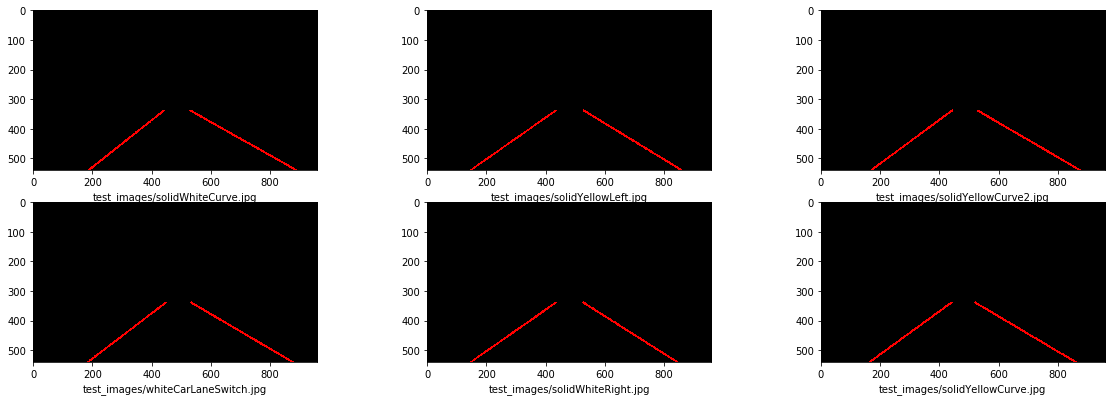

In [12]:
hough_images = transform_images(roi_images, hough_lines, rho=1, theta=np.pi/180,
                               threshold=20, min_line_len=5, max_line_gap=2)

In [13]:
def lane_pipeline(images, show_transform=False, show_output=True):
    print('Convert images to grayscale...')
    grayscale_images = transform_images(images, grayscale, 
                                        show_transform=show_transform)
    
    print('Apply a Gaussian blur to the images...')
    smoothed_images = transform_images(grayscale_images, gaussian_blur,
                                       kernel_size=7, show_transform=show_transform)
    
    print('Apply the Canny edge detection algorithm...')
    canny_images = transform_images(smoothed_images, canny, low_threshold=40,
                                    high_threshold=120, show_transform=show_transform)
 
    if len(images) == 6:
        height, width = canny_images[0].shape
    else:
        height, width = canny_images.shape
    
    print('Focus on a subset of the image...')
    roi_images = transform_images(canny_images, region_of_interest,
                                  vertices=np.array([[[round(width/2),round(height/2+38)],
                                                      [80,height],
                                                      [width-20,height]]]),
                                  show_transform=show_transform)
    
    print('Apply the Hough algorithm to detect lines...')
    hough_images = transform_images(roi_images, hough_lines, rho=1, theta=np.pi/180,
                                    threshold=40, min_line_len=20, max_line_gap=50,
                                    show_transform=show_transform)
    
    if len(images) == 6:
        weighted_images = [weighted_img(hough_image, test_image) 
                           for hough_image, test_image in zip(hough_images, images)]
    else:
        weighted_images = weighted_img(hough_images, images)
        
    if show_output:
        plot_images(weighted_images, grayscale=False)
    
    return weighted_images

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


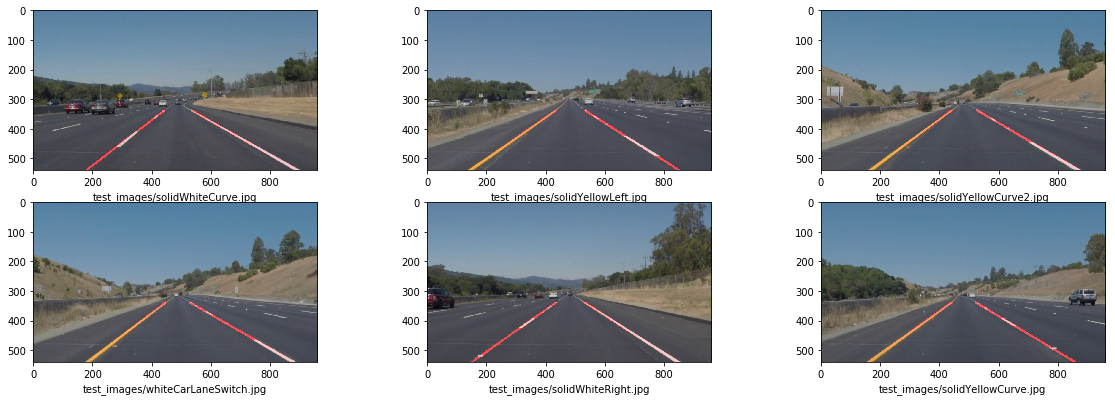

In [14]:
overlaid_images = lane_pipeline(test_images)

## Test on Videos

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image, show_transform=False, show_output=False):
    return lane_pipeline(image, show_transform=show_transform, show_output=show_output)

In [17]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False, codec='mpeg4')

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  3%|▎         | 6/222 [00:00<00:03, 55.45it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

  9%|▉         | 20/222 [00:00<00:03, 60.62it/s]

Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect

 15%|█▌        | 34/222 [00:00<00:03, 61.89it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 22%|██▏       | 49/222 [00:00<00:02, 65.19it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 28%|██▊       | 63/222 [00:00<00:02, 62.44it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 35%|███▌      | 78/222 [00:01<00:02, 67.37it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 39%|███▊      | 86/222 [00:01<00:01, 68.32it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 42%|████▏     | 94/222 [00:01<00:01, 71.17it/s]

Convert images to grayscale...


 46%|████▌     | 102/222 [00:01<00:01, 69.84it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 53%|█████▎    | 117/222 [00:01<00:01, 69.04it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 60%|█████▉    | 133/222 [00:01<00:01, 72.15it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 67%|██████▋   | 149/222 [00:02<00:01, 72.39it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 74%|███████▍  | 165/222 [00:02<00:00, 74.53it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 82%|████████▏ | 181/222 [00:02<00:00, 72.00it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 85%|████████▌ | 189/222 [00:02<00:00, 68.71it/s]

Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
A

 92%|█████████▏| 205/222 [00:02<00:00, 71.05it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

100%|█████████▉| 221/222 [00:03<00:00, 71.14it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [19]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False, codec='mpeg4')

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 5/682 [00:00<00:14, 45.56it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

  2%|▏         | 17/682 [00:00<00:13, 50.95it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

  4%|▍         | 30/682 [00:00<00:11, 56.14it/s]

Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algo

  6%|▋         | 44/682 [00:00<00:10, 61.19it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

  9%|▊         | 58/682 [00:00<00:10, 58.82it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 10%|█         | 71/682 [00:01<00:10, 60.90it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 11%|█▏        | 78/682 [00:01<00:09, 61.97it/s]

Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algo

 13%|█▎        | 86/682 [00:01<00:09, 66.12it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 14%|█▍        | 94/682 [00:01<00:08, 67.76it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 15%|█▌        | 103/682 [00:01<00:08, 71.22it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 16%|█▋        | 111/682 [00:01<00:07, 73.07it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 17%|█▋        | 119/682 [00:01<00:07, 74.94it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 19%|█▊        | 127/682 [00:01<00:07, 74.97it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 20%|█▉        | 135/682 [00:02<00:07, 75.14it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 21%|██        | 143/682 [00:02<00:07, 74.82it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 23%|██▎       | 160/682 [00:02<00:06, 75.11it/s]

Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect

 26%|██▌       | 176/682 [00:02<00:06, 74.71it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 28%|██▊       | 192/682 [00:02<00:06, 75.63it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 30%|███       | 208/682 [00:03<00:06, 74.40it/s]

Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algo

 33%|███▎      | 225/682 [00:03<00:06, 75.00it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 34%|███▍      | 233/682 [00:03<00:06, 74.20it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 35%|███▌      | 241/682 [00:03<00:05, 74.20it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 37%|███▋      | 249/682 [00:03<00:05, 73.52it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 38%|███▊      | 257/682 [00:03<00:05, 72.85it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 39%|███▉      | 266/682 [00:03<00:05, 74.52it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 41%|████▏     | 282/682 [00:04<00:05, 71.04it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 44%|████▎     | 298/682 [00:04<00:05, 70.06it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 45%|████▌     | 307/682 [00:04<00:05, 73.56it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 46%|████▌     | 315/682 [00:04<00:04, 73.62it/s]

Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...

 47%|████▋     | 323/682 [00:04<00:05, 69.69it/s]


Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
App

 50%|████▉     | 339/682 [00:04<00:04, 71.45it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 52%|█████▏    | 356/682 [00:05<00:04, 71.90it/s]

Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
A

 53%|█████▎    | 364/682 [00:05<00:04, 70.56it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 55%|█████▍    | 373/682 [00:05<00:04, 73.37it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...


 56%|█████▌    | 381/682 [00:05<00:04, 74.59it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 57%|█████▋    | 390/682 [00:05<00:03, 76.44it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 59%|█████▊    | 399/682 [00:05<00:03, 78.72it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 61%|██████    | 416/682 [00:05<00:03, 77.10it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 62%|██████▏   | 424/682 [00:05<00:03, 72.27it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 63%|██████▎   | 432/682 [00:06<00:03, 64.06it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 64%|██████▍   | 439/682 [00:06<00:04, 58.66it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 67%|██████▋   | 454/682 [00:06<00:03, 65.63it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 69%|██████▉   | 470/682 [00:06<00:03, 69.55it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 70%|███████   | 478/682 [00:06<00:02, 69.93it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 71%|███████▏  | 487/682 [00:06<00:02, 73.52it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...


 73%|███████▎  | 495/682 [00:07<00:02, 71.03it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 74%|███████▍  | 503/682 [00:07<00:02, 72.49it/s]

Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 75%|███████▍  | 511/682 [00:07<00:02, 72.30it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 76%|███████▌  | 519/682 [00:07<00:02, 72.52it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 77%|███████▋  | 527/682 [00:07<00:02, 71.97it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 78%|███████▊  | 535/682 [00:07<00:02, 72.80it/s]

Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 80%|███████▉  | 543/682 [00:07<00:01, 71.53it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 81%|████████  | 551/682 [00:07<00:01, 71.63it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 82%|████████▏ | 560/682 [00:07<00:01, 74.84it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 85%|████████▍ | 577/682 [00:08<00:01, 76.71it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 87%|████████▋ | 594/682 [00:08<00:01, 78.44it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 88%|████████▊ | 602/682 [00:08<00:01, 66.88it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 89%|████████▉ | 610/682 [00:08<00:01, 61.62it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 91%|█████████ | 619/682 [00:08<00:00, 66.57it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 92%|█████████▏| 627/682 [00:08<00:00, 68.92it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 93%|█████████▎| 635/682 [00:08<00:00, 71.64it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 94%|█████████▍| 643/682 [00:09<00:00, 71.90it/s]


Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
App

 95%|█████████▌| 651/682 [00:09<00:00, 72.79it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 97%|█████████▋| 659/682 [00:09<00:00, 71.91it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 98%|█████████▊| 667/682 [00:09<00:00, 73.99it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 99%|█████████▉| 675/682 [00:09<00:00, 73.84it/s]

Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
A

100%|█████████▉| 681/682 [00:09<00:00, 70.96it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 29.2 s, sys: 324 ms, total: 29.5 s
Wall time: 9.61 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

In [21]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False, codec='mpeg4')

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  2%|▏         | 4/251 [00:00<00:07, 33.49it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

  5%|▍         | 12/251 [00:00<00:06, 34.60it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

  8%|▊         | 20/251 [00:00<00:06, 35.80it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 10%|▉         | 24/251 [00:00<00:06, 36.06it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 12%|█▏        | 29/251 [00:00<00:06, 36.91it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...


 13%|█▎        | 33/251 [00:00<00:05, 36.90it/s]

Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
A

 16%|█▋        | 41/251 [00:01<00:05, 36.51it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 20%|█▉        | 49/251 [00:01<00:05, 36.64it/s]

Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algo

 23%|██▎       | 57/251 [00:01<00:05, 36.50it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 26%|██▋       | 66/251 [00:01<00:04, 37.93it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 28%|██▊       | 70/251 [00:01<00:04, 37.31it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 29%|██▉       | 74/251 [00:02<00:04, 36.47it/s]

Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...


 31%|███       | 78/251 [00:02<00:04, 36.27it/s]

Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
A

 33%|███▎      | 82/251 [00:02<00:04, 36.86it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 34%|███▍      | 86/251 [00:02<00:04, 35.84it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 37%|███▋      | 94/251 [00:02<00:04, 35.68it/s]

Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
A

 41%|████      | 102/251 [00:02<00:04, 36.03it/s]

Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
A

 44%|████▍     | 110/251 [00:03<00:03, 36.58it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 47%|████▋     | 118/251 [00:03<00:03, 36.72it/s]

Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
A

 49%|████▊     | 122/251 [00:03<00:03, 35.97it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 50%|█████     | 126/251 [00:03<00:03, 36.17it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...


 52%|█████▏    | 130/251 [00:03<00:03, 35.54it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 55%|█████▍    | 138/251 [00:03<00:03, 35.17it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 57%|█████▋    | 142/251 [00:03<00:03, 34.34it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 58%|█████▊    | 146/251 [00:04<00:03, 33.73it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...


 60%|█████▉    | 150/251 [00:04<00:02, 33.82it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 61%|██████▏   | 154/251 [00:04<00:02, 34.37it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...


 63%|██████▎   | 158/251 [00:04<00:02, 34.07it/s]

Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
A

 66%|██████▌   | 166/251 [00:04<00:02, 34.15it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 70%|██████▉   | 175/251 [00:04<00:02, 36.12it/s]

Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algo

 71%|███████▏  | 179/251 [00:04<00:01, 36.11it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 73%|███████▎  | 183/251 [00:05<00:01, 35.76it/s]

Convert images to grayscale...


 75%|███████▍  | 187/251 [00:05<00:01, 36.08it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 78%|███████▊  | 196/251 [00:05<00:01, 36.12it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 81%|████████▏ | 204/251 [00:05<00:01, 36.02it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 84%|████████▍ | 212/251 [00:05<00:01, 36.17it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 88%|████████▊ | 221/251 [00:06<00:00, 37.76it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 90%|████████▉ | 225/251 [00:06<00:00, 38.12it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

 94%|█████████▎| 235/251 [00:06<00:00, 39.85it/s]

Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Appl

 97%|█████████▋| 243/251 [00:06<00:00, 39.09it/s]

Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images

100%|██████████| 251/251 [00:06<00:00, 36.47it/s]

Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
Apply the Hough algorithm to detect lines...
Convert images to grayscale...
Apply a Gaussian blur to the images...
Apply the Canny edge detection algorithm...
Focus on a subset of the image...
A

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))